# **딥러닝팀 클린업 3주차 코딩 실습**

> 🖥**Produced by 김예찬 (feat. 지멘, 구글링)**



---
> 3주차에는 자연어처리(NLP) 분야의 딥러닝 모델을 학습해볼 예정입니다. 

> NLP에서는 RNN을 기반으로 하는 모델들이 주로 사용되므로, 오늘은 Attention 기법을 적용한 Seq2Seq 모델을 활용하여 영어와 한국어 간의 기계번역 과제를 수행해볼 예정입니다.

> 더불어, 딥러닝 모델을 학습할 때는 물론, 강화학습 알고리즘을 학습할 때도 사용가능한 Tensorboard라는 것을 사용해볼 것입니다. Tensorboard는 모델의 학습 과정에서 loss나 정확도, 파라미터의 값 등을 추적할 수 있도록 도와주는 기능이며, tensorflow라는 딥러닝 프레임워크의 기능이지만 pytorch에서도 사용이 가능합니다.
---


### **0-1) Drive Mount**

In [ ]:
# Drive Mount

from google.colab import drive
drive.mount('/content/gdrive')

# Working Directory 변경

import os

directory = "" # 파일이 있는 디렉토리
path = "/content/gdrive/My Drive/" + directory
os.chdir(path)

Mounted at /content/gdrive


### **0-2) 한글 깨짐 현상**

In [ ]:
import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib as mpl

!apt-get update -qq
!apt-get install fonts-nanum* -qq

path = '/usr/share/fonts/truetype/nanum/NanumBarunGothic.ttf' 
font_name = fm.FontProperties(fname=path, size=10).get_name()
print(font_name)
plt.rc('font', family=font_name)

fm._rebuild()
mpl.rcParams['axes.unicode_minus'] = False
font = fm.FontProperties(fname=path, size=9)
plt.rc('font', family='NanumBarunGothic')

Selecting previously unselected package fonts-nanum.
(Reading database ... 155335 files and directories currently installed.)
Preparing to unpack .../fonts-nanum_20170925-1_all.deb ...
Unpacking fonts-nanum (20170925-1) ...
Selecting previously unselected package fonts-nanum-eco.
Preparing to unpack .../fonts-nanum-eco_1.000-6_all.deb ...
Unpacking fonts-nanum-eco (1.000-6) ...
Selecting previously unselected package fonts-nanum-extra.
Preparing to unpack .../fonts-nanum-extra_20170925-1_all.deb ...
Unpacking fonts-nanum-extra (20170925-1) ...
Selecting previously unselected package fonts-nanum-coding.
Preparing to unpack .../fonts-nanum-coding_2.5-1_all.deb ...
Unpacking fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-extra (20170925-1) ...
Setting up fonts-nanum (20170925-1) ...
Setting up fonts-nanum-coding (2.5-1) ...
Setting up fonts-nanum-eco (1.000-6) ...
Processing triggers for fontconfig (2.12.6-0ubuntu2) ...
NanumBarunGothic


### **0-3) 시드 고정**

In [ ]:
import random
import numpy as np

def seed_everything(seed: int = 824):
    random.seed(seed)
    np.random.seed(seed)
    os.environ["PYTHONHASHSEED"] = str(seed)
random_state = 824
seed_everything(random_state)

## **1. 데이터 전처리**

---
> 영어와 한국어의 조합으로 이루어진 eng_to_kor.txt 텍스트 데이터를 불러오고, 텍스트 데이터를 숫자 데이터로 바꿔주는 class를 구현하여 Seq2Seq에 대입할 수 있는 입력 데이터를 준비해볼 것입니다. 

> 3주차 클린업에서 배운 임베딩(Embedding) 등을 떠올려 봅시다!
---


In [ ]:
from __future__ import unicode_literals, print_function, division
from io import open
import numpy as np
import unicodedata
import string
import re
import random
import math
import time

import torch
import torch.nn as nn
from torch import optim
import torch.nn.functional as F

%matplotlib inline

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

### **1-1) 데이터 불러오기**

---
> 오늘 만들어볼 기계번역 모델은 영어를 한국어로 번역하는 것을 목적으로 합니다. 데이터에 어떤 문장들이 있는지 한 번 확인해보도록 하겠습니다.

> 아래의 15개 문장은 매우 짧지만, 해당 .txt 파일에는 이렇게 짧은 문장부터 긴 문장까지 여러가지 문장들이 포함되어 있습니다.
---

In [ ]:
# 데이터 불러오기

data = open("./test/PSAT/3주차 코딩실습/eng_to_kor.txt", "r")

In [ ]:
# 데이터 확인

for i in range(15):
    print(data.readline())

Go.	가.

Hi.	안녕.

Run!	뛰어!

Run.	뛰어.

Who?	누구?

Wow!	우와!

Fire!	쏴!

Help!	도와줘!

Jump!	점프!

Jump.	점프해.

Wait!	기다려!

Wait!	잠깐!

Wait.	기다려.

Begin.	시작해.

Hello!	안녕!



### **1-2) Word Indexing**

---
> Seq2Seq는 RNN을 베이스로 하는 Encoder-Decoder 구조이기 때문에 순차적으로 입력이 들어가게 됩니다. 따라서 우리의 텍스트 데이터에 순차적으로 번호를 붙여줄 예정인데, 이를 Word Indexing이라고 합니다.
---

In [ ]:
# Word Indexing을 위한 class 구현

SOS_token = 0 # Start of Sentence 토큰 (Decoder의 첫 입력)
EOS_token = 1 # End of Sentence 토큰 (Decoder의 마지막 출력)


class Lang:
    # __init__ 함수는 이 class의 객체가 처음 정의되는 순간 아래의 dictionary들이 자동으로 생성됨을 의미합니다.
    def __init__(self, name):
        self.name = name
        self.word2index = {}
        self.word2count = {}
        self.index2word = {0: "SOS", 1: "EOS"}
        self.n_words = 2  # SOS 와 EOS 포함

    # 문장을 입력받아 띄어쓰기 단위로 끊고, 여기서 얻은 단어들을 dictionary에 저장합니다.
    def addSentence(self, sentence):
        for word in sentence.split(' '):
            self.addWord(word)
    
    # 문장 속에 있는 단어들을 dictionary에 저장하는 동시에 단어의 빈도수를 카운트합니다.
    def addWord(self, word):
        if word not in self.word2index:
            self.word2index[word] = self.n_words
            self.word2count[word] = 1
            self.index2word[self.n_words] = word
            self.n_words += 1
        else:
            self.word2count[word] += 1

### **1-3) 데이터 정제**

---
> 3주타 클린업에서 배웠듯이, 자연어를 전처리할 때는 의미를 해석하는 것에 도움이 되지 않는 요소들을 최대한 제거합니다. 예를 들면, 고유명사 등을 제외한 단어들은 소문자/대문자 여부가 의미에 영향을 끼치지 않기 때문에, 제거해줍니다.

> 지금은 간단한 번역 모델만 구현하는 것이므로, 구두점만 제거해주도록 하겠습니다.
---

In [ ]:
# 문자가 아닌 문자 제거 (의미에 영향을 주지 않는 요소들 제거)

def normalizeString(s):
    s = re.sub(r"([.!?])", r" \1", s)
    return s


### **1-4) 데이터 분리**

---
> 여기서 말하는 데이터 분리란, 영어와 한국어 데이터가 모두 들어있는 .txt 데이터를 영어 데이터셋과 한국어 데이터셋으로 분리하는 것을 의미합니다. 한 마디로, (X, y) 형태로 분리하는 것과 동일합니다.

> 학습의 편의를 위해 종료 부호를 포함하여 총 20단어 이내의 문장에 대해서만 학습을 진행하도록 하겠습니다.
---

In [ ]:
# 학습 데이터와 타겟 데이터 분리

def readLangs(lang1, lang2, reverse=False):
    print("Reading lines...")

    # 파일을 읽고 줄로 분리
    lines = open('./test/PSAT/3주차 코딩실습/%s_to_%s.txt' % (lang1, lang2), encoding='utf-8').\
        read().strip().split('\n')

    # 모든 줄을 쌍으로 분리하고 정규화(구두점 제거)
    pairs = [[normalizeString(s) for s in l.split('\t')] for l in lines]

    # 쌍을 뒤집고, Lang 인스턴스 생성
    if reverse: 
        pairs = [list(reversed(p)) for p in pairs]    # 현재 모델은 영어 --> 한국어이지만, reverse를 적용하면 한국어 --> 영어가 됩니다!
        input_lang = Lang(lang2)
        output_lang = Lang(lang1)
    else:
        input_lang = Lang(lang1)
        output_lang = Lang(lang2)

    return input_lang, output_lang, pairs

In [ ]:
# 영어와 한국어 모두 20 단어 이내로 설정

MAX_LENGTH = 20

def filterPair(p):
    return len(p[0].split(' ')) < MAX_LENGTH and len(p[1].split(' ')) < MAX_LENGTH 

def filterPairs(pairs):
    return [pair for pair in pairs if filterPair(pair)]

### **1-5) DataLoader 준비**

---
> 앞서 만든 class들과 함수들을 바탕으로 최종적으로 데이터를 반환해주는 Loader를 구현합니다. 구체적으로 다음의 절차에 따라 우리가 모델에 사용할 데이터들을 전달합니다.

1.   텍스트 파일을 읽어들인 후 줄로 분리하며, 영어와 한국어의 쌍으로 분리합니다. 
2.   텍스트를 정제하고, 길이가 20 단어가 넘는 문장들을 제거합니다.
3.   (영어, 한국어)의 상을 이룬 문장들을 바탕으로 단어의 리스트를 생성합니다.
---


In [ ]:
# 입력 데이터의 형식에 맞게 데이터 반환

def prepareData(lang1, lang2, reverse=False):
    input_lang, output_lang, pairs = readLangs(lang1, lang2, reverse)
    print("Read %s sentence pairs" % len(pairs))
    pairs = filterPairs(pairs)
    print("Trimmed to %s sentence pairs" % len(pairs))
    print("Counting words...")
    for pair in pairs:
        input_lang.addSentence(pair[0])
        output_lang.addSentence(pair[1])
    print("Counted words:")
    print(input_lang.name, input_lang.n_words)
    print(output_lang.name, output_lang.n_words)
    return input_lang, output_lang, pairs


input_lang, output_lang, pairs = prepareData('eng', 'kor', False)
print(random.choice(pairs))

Reading lines...
Read 3798 sentence pairs
Trimmed to 3792 sentence pairs
Counting words...
Counted words:
eng 2986
kor 5737
["Let's hear the rest of the story .", '이야기를 마저 들어 봅시다 .']


In [ ]:
# 입출력 데이터 모두 tensor로 변환 + sos & eos 토큰 넣기

def indexesFromSentence(lang, sentence):
    return [lang.word2index[word] for word in sentence.split(' ')]


def tensorFromSentence(lang, sentence):
    indexes = indexesFromSentence(lang, sentence)
    indexes.append(EOS_token)
    return torch.tensor(indexes, dtype=torch.long, device=device).view(-1, 1)


def tensorsFromPair(pair):
    input_tensor = tensorFromSentence(input_lang, pair[0])
    target_tensor = tensorFromSentence(output_lang, pair[1])
    return (input_tensor, target_tensor)

## **3. 모델링**

---
> 이제 모델을 만들어보겠습니다! 저번주와 마찬가지로 Pytorch를 사용하여 모델을 구현할 예정이며, Encoder-Decoder 구조를 기반으로 하는 Seq2Seq 모델에 Attention 기법을 추가할 예정입니다. 따라서, 크게 Encoder, Decoder 2가지 모델을 만든 후 이 2가지 모델을 병합하는 방식으로 최종 모델을 구현할 것입니다.
---

### **3-1) 모델 정의**

---


1. Encoder: 영어 입력 문장들을 임베딩한 후 GRU 유닛으로 통과시킵니다. 
   * 영어 입력 문장들을 임베딩(벡터의 형태로 표현)
   * GRU 유닛을 통과시켜 Hidden State 연산
   * Hidden State를 출력으로 반환


2. Decoder: Encoder의 마지막 Hidden State와 한국어를 입력으로 받아 번역
   * 한국어 입력 문장들을 임베딩
   * GRU 유닛을 통과시켜 Hidden State와 Output 연산
   * 매 시점 Output을 차례로 FC Layer, Softmax에 통과시켜 나올 수 있는 번역된 단어 반환


3. Attention Decoder: Decoder와 구조는 동일하지만 Attention 기법 적용
   * 클린업에서 배운 Dot Product Attention 기법 대신 FC Layer를 사용하여 Attention Score를 계산하는 방법 적용


---



In [ ]:
# Encoder 정의

class EncoderRNN(nn.Module):
    def __init__(self, input_size, hidden_size):
        super(EncoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(input_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)

    def forward(self, input, hidden):
        embedded = self.embedding(input).view(1, 1, -1)
        output = embedded
        output, hidden = self.gru(output, hidden)
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)  # device는 2주차 실습에서 별도로 .to('cuda')를 모델 내에서 미리 하는 것!

In [ ]:
# Decoder 정의 - Seq2Seq

class DecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size):
        super(DecoderRNN, self).__init__()
        self.hidden_size = hidden_size

        self.embedding = nn.Embedding(output_size, hidden_size)
        self.gru = nn.GRU(hidden_size, hidden_size)
        self.out = nn.Linear(hidden_size, output_size)
        self.softmax = nn.LogSoftmax(dim=1)

    def forward(self, input, hidden):
        output = self.embedding(input).view(1, 1, -1)
        output = F.relu(output)
        output, hidden = self.gru(output, hidden)
        output = self.softmax(self.out(output[0]))
        return output, hidden

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
# Attention Decoder 정의

class AttnDecoderRNN(nn.Module):
    def __init__(self, hidden_size, output_size, dropout_p=0.1, max_length=MAX_LENGTH):
        super(AttnDecoderRNN, self).__init__()
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.dropout_p = dropout_p
        self.max_length = max_length

        self.embedding = nn.Embedding(self.output_size, self.hidden_size)
        self.attn = nn.Linear(self.hidden_size * 2, self.max_length)
        self.attn_combine = nn.Linear(self.hidden_size * 2, self.hidden_size)
        self.dropout = nn.Dropout(self.dropout_p)
        self.gru = nn.GRU(self.hidden_size, self.hidden_size)
        self.out = nn.Linear(self.hidden_size, self.output_size)

    def forward(self, input, hidden, encoder_outputs):
        embedded = self.embedding(input).view(1, 1, -1)
        embedded = self.dropout(embedded)

        attn_weights = F.softmax(
            self.attn(torch.cat((embedded[0], hidden[0]), 1)), dim=1)
        attn_applied = torch.bmm(attn_weights.unsqueeze(0),
                                 encoder_outputs.unsqueeze(0))

        output = torch.cat((embedded[0], attn_applied[0]), 1)
        output = self.attn_combine(output).unsqueeze(0)

        output = F.relu(output)
        output, hidden = self.gru(output, hidden)

        output = F.log_softmax(self.out(output[0]), dim=1)
        return output, hidden, attn_weights

    def initHidden(self):
        return torch.zeros(1, 1, self.hidden_size, device=device)

In [ ]:
print(EncoderRNN(20, 128))

EncoderRNN(
  (embedding): Embedding(20, 128)
  (gru): GRU(128, 128)
)


### **3-2) 모델 개요 확인**

In [ ]:
from torchinfo import summary

summary(EncoderRNN(20, 128))

Layer (type:depth-idx)                   Param #
EncoderRNN                               --
├─Embedding: 1-1                         2,560
├─GRU: 1-2                               99,072
Total params: 101,632
Trainable params: 101,632
Non-trainable params: 0

In [ ]:
summary(DecoderRNN(128, 20))

Layer (type:depth-idx)                   Param #
DecoderRNN                               --
├─Embedding: 1-1                         2,560
├─GRU: 1-2                               99,072
├─Linear: 1-3                            2,580
├─LogSoftmax: 1-4                        --
Total params: 104,212
Trainable params: 104,212
Non-trainable params: 0

In [ ]:
summary(AttnDecoderRNN(128, 20))

Layer (type:depth-idx)                   Param #
AttnDecoderRNN                           --
├─Embedding: 1-1                         2,560
├─Linear: 1-2                            5,140
├─Linear: 1-3                            32,896
├─Dropout: 1-4                           --
├─GRU: 1-5                               99,072
├─Linear: 1-6                            2,580
Total params: 142,248
Trainable params: 142,248
Non-trainable params: 0

## **4. 학습 및 평가**

### **4-1) 모델 학습 준비**

In [ ]:
# train 함수 정의 - 교사강요 포함!

teacher_forcing_ratio = 0.5


def train(input_tensor, target_tensor, encoder, decoder, encoder_optimizer, decoder_optimizer, criterion, max_length=MAX_LENGTH):
    encoder_hidden = encoder.initHidden()

    encoder_optimizer.zero_grad()
    decoder_optimizer.zero_grad()

    input_length = input_tensor.size(0)
    target_length = target_tensor.size(0)

    encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

    loss = 0

    for ei in range(input_length):
        encoder_output, encoder_hidden = encoder(
            input_tensor[ei], encoder_hidden)
        encoder_outputs[ei] = encoder_output[0, 0]

    decoder_input = torch.tensor([[SOS_token]], device=device)

    decoder_hidden = encoder_hidden

    use_teacher_forcing = True if random.random() < teacher_forcing_ratio else False

    if use_teacher_forcing:
        # Teacher forcing 포함: 목표를 다음 입력으로 전달
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            loss += criterion(decoder_output, target_tensor[di])
            decoder_input = target_tensor[di]  # Teacher forcing

    else:
        # Teacher forcing 미포함: 자신의 예측을 다음 입력으로 사용
        for di in range(target_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            topv, topi = decoder_output.topk(1)
            decoder_input = topi.squeeze().detach()  # 입력으로 사용할 부분을 히스토리에서 분리

            loss += criterion(decoder_output, target_tensor[di])
            if decoder_input.item() == EOS_token:
                break

    loss.backward()

    encoder_optimizer.step()
    decoder_optimizer.step()

    return loss.item() / target_length

In [ ]:
import matplotlib.pyplot as plt
plt.switch_backend('agg')
import matplotlib.ticker as ticker
import numpy as np

# 결과 시각화

def showPlot(points):
    plt.figure()
    fig, ax = plt.subplots()
    loc = ticker.MultipleLocator(base=0.2)
    ax.yaxis.set_major_locator(loc)
    plt.plot(points)

In [ ]:
# 학습 시간 및 소요 시간 계산

def asMinutes(s):
    m = math.floor(s / 60)
    s -= m * 60
    return '%dm %ds' % (m, s)


def timeSince(since, percent):
    now = time.time()
    s = now - since
    es = s / (percent)
    rs = es - s
    return '%s (- %s)' % (asMinutes(s), asMinutes(rs))

In [ ]:
# Tensorboard 사용 준비

from torch.utils.tensorboard import SummaryWriter
writer = SummaryWriter()

In [ ]:
# 전체 학습 Flow 완성!

def trainIters(encoder, decoder, n_iters, print_every=1000, plot_every=100, learning_rate=0.01):
    start = time.time()
    plot_losses = []
    print_loss_total = 0  # print_every 마다 초기화
    plot_loss_total = 0   # plot_every 마다 초기화

    encoder_optimizer = optim.SGD(encoder.parameters(), lr=learning_rate) # Encoder의 Optim
    decoder_optimizer = optim.SGD(decoder.parameters(), lr=learning_rate) # Decoder의 Optim
    training_pairs = [tensorsFromPair(random.choice(pairs))
                      for i in range(n_iters)]
    criterion = nn.NLLLoss()

    for iter in range(1, n_iters + 1):
        training_pair = training_pairs[iter - 1]
        input_tensor = training_pair[0]
        target_tensor = training_pair[1]

        loss = train(input_tensor, target_tensor, encoder,
                     decoder, encoder_optimizer, decoder_optimizer, criterion)
        writer.add_scalar("Loss", loss, iter)                            # Encoder의 loss 저장
        print_loss_total += loss
        plot_loss_total += loss

        if iter % print_every == 0:
            print_loss_avg = print_loss_total / print_every
            print_loss_total = 0
            print('%s (%d %d%%) %.4f' % (timeSince(start, iter / n_iters),
                                         iter, iter / n_iters * 100, print_loss_avg))

        if iter % plot_every == 0:
            plot_loss_avg = plot_loss_total / plot_every
            plot_losses.append(plot_loss_avg)
            plot_loss_total = 0

    showPlot(plot_losses)

### **4-2) 모델 학습**

-----
> 본격적으로 모델 학습을 시작해보겠습니다. 1주차에서 살펴본 바와 같이, 딥러닝에서 학습은 보통 손실함수의 값을 최소화시키는 과정을 따라 이루어지며, 그 과정에서 학습 데이터 및 검증 데이터에 대한 예측의 정확도가 올라가게 됩니다. 때문에, 손실함수 값의 변동 추이 또한 예측의 정확도만큼 중요한 평가 요소라고 할 수 있습니다. 따라서, 학습을 진행할 때 두 데이터에 대한 손실함수 값의 변동과 정확도의 변동을 항상 별도의 list에 저장해놓는 코딩 습관을 들여놓는 것이 좋습니다. 시간을 측정하는 습관도 마찬가지입니다!

> Epoch는 전체 데이터셋을 몇 번 재활용하여 학습을 진행할 것인지를 의미합니다. 아래와 같이 epoch가 30으로 되어 있으면, 전체 데이터셋을 30번 반복해서 학습할 것이라는 뜻입니다. 

> 아래의 학습 코드는 모델의 종류에 따라 조금은 바뀔 수 있겠지만, 큰 틀에서 딥러닝 모델들은 대부분 아래의 코드와 유사한 형태의 코드로 학습을 진행합니다. 따라서, 아래 코드를 잘 익혀두면 앞으로도 편하게 사용할 수 있습니다. 코드가 복잡하므로, 한 줄 한 줄 이해하고 넘어가길 바랍니다!
-----

In [ ]:
hidden_size = 128
encoder1 = EncoderRNN(input_lang.n_words, hidden_size).to(device)
attn_decoder1 = AttnDecoderRNN(hidden_size, output_lang.n_words, dropout_p=0.1).to(device)

trainIters(encoder1, attn_decoder1, 100000, print_every=2000)

writer.flush()
writer.close()

0m 49s (- 40m 42s) (2000 2%) 5.0202
1m 30s (- 36m 3s) (4000 4%) 5.0114
2m 15s (- 35m 26s) (6000 6%) 4.8920
2m 57s (- 34m 1s) (8000 8%) 4.7364
3m 38s (- 32m 50s) (10000 10%) 4.6394
4m 20s (- 31m 49s) (12000 12%) 4.4759
5m 1s (- 30m 52s) (14000 14%) 4.3749
5m 43s (- 30m 0s) (16000 16%) 4.2596
6m 24s (- 29m 11s) (18000 18%) 4.1226
7m 5s (- 28m 21s) (20000 20%) 3.9746
7m 46s (- 27m 35s) (22000 22%) 3.8735
8m 27s (- 26m 48s) (24000 24%) 3.7415
9m 9s (- 26m 3s) (26000 26%) 3.6211
9m 50s (- 25m 19s) (28000 28%) 3.4939
10m 32s (- 24m 36s) (30000 30%) 3.3449
11m 14s (- 23m 52s) (32000 32%) 3.2235
11m 55s (- 23m 8s) (34000 34%) 3.1012
12m 37s (- 22m 26s) (36000 36%) 2.9879
13m 19s (- 21m 44s) (38000 38%) 2.8256
14m 1s (- 21m 2s) (40000 40%) 2.7176
14m 46s (- 20m 24s) (42000 42%) 2.6389
15m 28s (- 19m 41s) (44000 44%) 2.5138
16m 12s (- 19m 1s) (46000 46%) 2.4492
16m 57s (- 18m 22s) (48000 48%) 2.3232
17m 41s (- 17m 41s) (50000 50%) 2.2427
18m 23s (- 16m 58s) (52000 52%) 2.1067
19m 5s (- 16m 16s) 

### **4-3) 결과 시각화**

---
> Tensorboard를 사용하여 Loss의 변화 과정을 추적해보겠습니다. Tensorboard가 일반 plot들보다 좋은 이유는, 사용자가 그래프와 상호작용하는 것이 가능하기 때문입니다. Tensorboard에는 Loss나 Accuracy 시각화 이외에도 정말 다양한 가능한 기능이 있으므로, 한 번 찾아보시기 바랍니다!
---

In [ ]:
# Tensorboard 사용 환경 준비

! pip install jupyter-tensorboard
! docker pull lspvic/tensorboard-notebook
! docker run -it --rm -p 8888:8888 lspvic/tensorboard-notebook

In [ ]:
# tfevent 파일 tensorboard에서 확인
 # 한 번 더 확인할 때는 reload_ext

%load_ext tensorboard 
%tensorboard --logdir ./runs/Mar12_06-49-04_fa77f294e477 # tfevent 파일이 위치하고 있는 디렉토리

### **4-4) Attention 시각화**

---
> 딥러닝 모델의 가장 큰 단점이라고 불리는 것이 바로 딥러닝은 블랙박스 모델이라는 것입니다. 딥러닝이 어떻게 진행되었는지 설명할수가 없다는 점인데요, 이를 극복하기 위해 나온 인공지능 모델이 바로 설명 가능한 인공지능(XAI) 입니다. Attention 기법은 출력이 입력의 어떤 부분을 특히 집중해서 보아야 할지 결정해준다는 점에서 XAI 기법의 하나입니다.

> 따라서, 임의의 영어 문장을 넣어 한국어 문장으로 번역이 진행될 때 정확히 입력 문장의 어떤 부분에 집중하는지 확인해보도록 하겠습니다.
---

In [ ]:
def evaluate(encoder, decoder, sentence, max_length=MAX_LENGTH):
    with torch.no_grad():
        input_tensor = tensorFromSentence(input_lang, sentence)
        input_length = input_tensor.size()[0]
        encoder_hidden = encoder.initHidden()

        encoder_outputs = torch.zeros(max_length, encoder.hidden_size, device=device)

        for ei in range(input_length):
            encoder_output, encoder_hidden = encoder(input_tensor[ei],
                                                     encoder_hidden)
            encoder_outputs[ei] += encoder_output[0, 0]

        decoder_input = torch.tensor([[SOS_token]], device=device)  # SOS

        decoder_hidden = encoder_hidden

        decoded_words = []
        decoder_attentions = torch.zeros(max_length, max_length)

        for di in range(max_length):
            decoder_output, decoder_hidden, decoder_attention = decoder(
                decoder_input, decoder_hidden, encoder_outputs)
            decoder_attentions[di] = decoder_attention.data
            topv, topi = decoder_output.data.topk(1)
            if topi.item() == EOS_token:
                decoded_words.append('<EOS>')
                break
            else:
                decoded_words.append(output_lang.index2word[topi.item()])

            decoder_input = topi.squeeze().detach()

        return decoded_words, decoder_attentions[:di + 1]

번역 문장:  일본에는 펭귄을 키우는 사람이 있대 . <EOS>


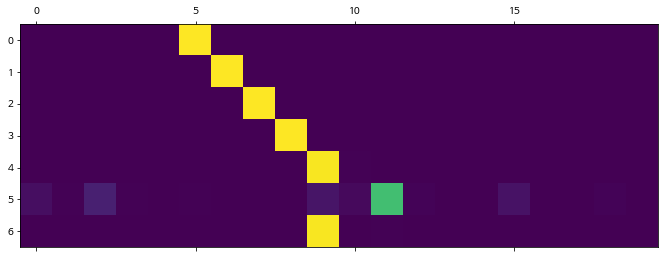

In [ ]:
# Attention Value 확인

output_words, attentions = evaluate(encoder1, attn_decoder1, "I hear that there are people in Japan that keep penguins as pets .")
print("번역 문장: ", ' '.join(output_words))
plt.matshow(attentions.numpy())

### **4-5) 결과 확인**

In [ ]:
def evaluateRandomly(encoder, decoder, n=10):
    for i in range(n):
        pair = random.choice(pairs)
        print('>', pair[0])
        print('=', pair[1])
        output_words, attentions = evaluate(encoder, decoder, pair[0])
        output_sentence = ' '.join(output_words)
        print('<', output_sentence)
        print('')

In [ ]:
evaluateRandomly(encoder1, attn_decoder1, n=15)

> Lack of sleep is bad for the body .
= 수면 부족은 몸에 나빠 .
< 수면 부족은 몸에 나빠 . <EOS>

> Do you believe this has any use ?
= 이게 쓸모가 있을거라고 생각해 ?
< 이게 쓸모가 있을거라고 생각해 ? <EOS>

> All of us have some interest in history . In a sense, we are all historians .
= 우리 다 역사에 관심이 있어서 어떤 의미로 우리는 모두 역사가다 .
< 우리 다 역사에 어떤 어떤 찾을 수 의미로 우리는 모두 . <EOS>

> The earth is far bigger than the moon .
= 지구는 달보다 훨씬 커 .
< 지구는 달보다 훨씬 커 . <EOS>

> Nobody died .
= 아무도 죽지 않았어 .
< 아무도 안 죽었어 . <EOS>

> You can learn French .
= 넌 프랑스어를 배울 수 있어 .
< 넌 프랑스어를 배울 수 있어 . <EOS>

> I envy you .
= 네가 부러워 .
< 네가 부러워 . <EOS>

> You'll soon get used to the noise .
= 넌 곧 소음에 익숙해질거야 .
< 넌 곧 소음에 익숙해질거야 . <EOS>

> Would you mind answering a few questions ?
= 몇 가지 질문에 답할 의향 있어 ?
< 몇 몇 질문에 답할 있니 ? <EOS>

> How many of the people here are teachers ?
= 여기에 있는 사람 중 몇명이 선생님이야 ?
< 여기에 있는 사람 중 몇명이 선생님이야 ? <EOS>

> Step back .
= 물러서 .
< 물러서 . <EOS>

> Oh no !
= 아니 이런 !
< 아니 이런 ! <EOS>

> He came out of the shower naked .
= 그는 알몸으로 샤워실에서 나왔다 .
< 그는 알몸으로 샤워

## **5. 마무리**

---
> 지금까지 NLP의 대표적 과제 중 하나인 기계번역을 Seq2Seq와 Attention 기법을 활용하여 수행해보았습니다. 저도 개인적으로 딥러닝을 활용한 자연어처리를 해본 적이 없어서 Pytorch의 튜토리얼을 바탕으로 실습 내용을 구성하며 많은 공부가 된 것 같습니다. 데이터의 크기가 매우 작다는 점, 그리고 가장 간단한 구조를 사용했다는 점에서 실제 대화에서 오가는 표현을 번역하는 것에는 무리가 있을 것입니다. 하지만, Encoder-Decoder가 어떻게 구현되는지, RNN 게열의 모델은 pytorch에서 어떻게 사용할 수 있는지를 알아볼 수 있었습니다. 이 부분도 2주차 실습과 더불어 한 줄 한 줄 복습해보시기 바랍니다!
---




